# พลอตข้อมูลด้วยไดอะแกรม Hovmoller diagram
* ต้องการดูข้อมูล u component ด้วยการเฉลี่ยตามแนวละติจูดของข้อมูล reanalysis ในแต่ละช่วงเวลา แล้วนำมาแสดงเพื่อศึกษาไดนามิกส์ของการเคลื่อนที่ของ u component ในแต่ละภูมิภาคของโลก
* ดาวน์โหลดข้อมูล era5 แบบรายชั่วโมง ระดับ 850mb ด้วยการเลือก 00, 06, 12, 18 UTC จากวันที่ 1 กันยายน -31 ตุลาคม ปีค.ศ 2011 จากลิงก์ https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview
* ข้อมูลโค้ดการพลอต Hovmoller diagram จากลิงก์ https://unidata.github.io/python-gallery/examples/Hovmoller_Diagram.html



In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
%matplotlib inline

## 1.จัดการข้อมูล

In [16]:
#อ่านข้อมูล
ds = xr.open_dataset('era5_hourly4_sep_oct_2011_globe.nc')
print(ds)

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 244)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2011-09-01 ... 2011-10-31T18:00:00
Data variables:
    u          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-17 06:20:18 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...


In [17]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 244)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2011-09-01 ... 2011-10-31T18:00:00
Data variables:
    u          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-17 06:20:18 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

### เลือกข้อมูลให้เล็กลงเน้นเฉพาะพื้นที่อินโดจีนและบริเวณโดยรอบ และทำการประมาณค่าใหม่ให้เหลือ 0.5 deg เพื่อทำการประมวลผลได้เร็วขึ้น 

In [4]:
#ds = ds.sel(longitude=np.arange(60, 130, 0.5), latitude=np.arange(-5, 45, 0.5), method='nearest') # 0.5 คือกริดใหม่ที่ต้องการจากการประมาณค่าด้วย nearest

In [5]:
# จัดเก็บตัวแปรที่ต้องใช้
x = ds.longitude
y = ds.latitude
u = ds.u

In [6]:
# Create time slice from dates
start_time = '2011-10-02'
end_time = '2011-10-05'

# Select ERA5 parameter and level
param = 'u'
level = 850

In [7]:
# Create slice variables subset domain
time_slice = slice(start_time, end_time)
lat_slice = slice(25, 10)
lon_slice = slice(0, 360)

In [8]:
# Get data, selecting time, level, lat/lon slice
data = ds[param].sel(time=time_slice,
                     #level=level,
                     latitude=lat_slice,
                     longitude=lon_slice)

In [9]:
data

<xarray.DataArray 'u' (time: 16, latitude: 61, longitude: 1440)>
[1405440 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 2011-10-02 ... 2011-10-05T18:00:00
Attributes:
    units:          m s**-1
    long_name:      U component of wind
    standard_name:  eastward_wind

In [10]:
# Compute weights and take weighted average over latitude dimension
weights = np.cos(np.deg2rad(data.latitude.values))
avg_data = (data * weights[None, :, None]).sum(dim='latitude') / np.sum(weights)

In [11]:
# Get times and make array of datetime objects
utimes = data.time.values.astype('datetime64[ms]').astype('O')

In [12]:
utimes

array([datetime.datetime(2011, 10, 2, 0, 0),
       datetime.datetime(2011, 10, 2, 6, 0),
       datetime.datetime(2011, 10, 2, 12, 0),
       datetime.datetime(2011, 10, 2, 18, 0),
       datetime.datetime(2011, 10, 3, 0, 0),
       datetime.datetime(2011, 10, 3, 6, 0),
       datetime.datetime(2011, 10, 3, 12, 0),
       datetime.datetime(2011, 10, 3, 18, 0),
       datetime.datetime(2011, 10, 4, 0, 0),
       datetime.datetime(2011, 10, 4, 6, 0),
       datetime.datetime(2011, 10, 4, 12, 0),
       datetime.datetime(2011, 10, 4, 18, 0),
       datetime.datetime(2011, 10, 5, 0, 0),
       datetime.datetime(2011, 10, 5, 6, 0),
       datetime.datetime(2011, 10, 5, 12, 0),
       datetime.datetime(2011, 10, 5, 18, 0)], dtype=object)

In [13]:
# Specify longitude values for chosen domain
lons = data.longitude.values

## 2.ทำการพลอต Hoevmoeller ข้อมูลที่ได้เตรียมไว้

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\Admin\anaconda3\envs\metpy\li

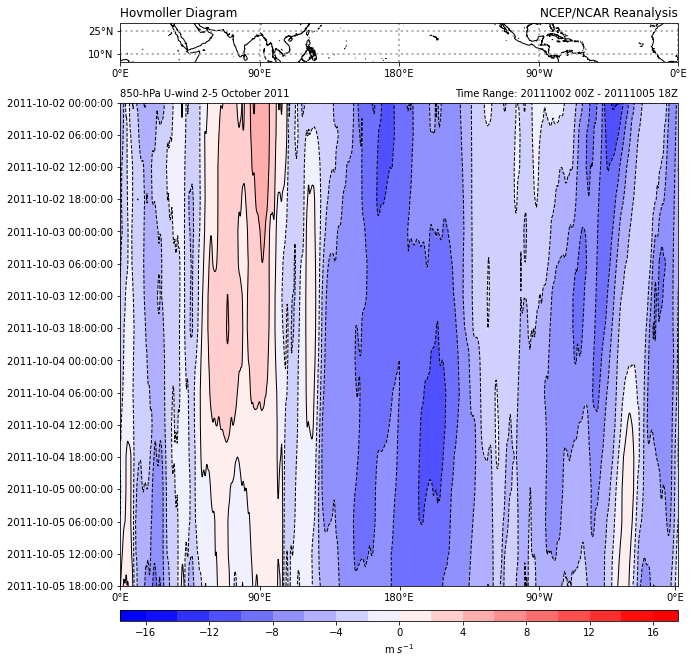

In [14]:
# Start figure
fig = plt.figure(figsize=(10, 13))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)

# Tick labels
x_tick_labels = [u'0\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'180\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}E']

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([0, 357.5, 5, 30], ccrs.PlateCarree(central_longitude=180))
#ax1.set_extent([80, 130, 5, 30], ccrs.PlateCarree(central_longitude=180))
#ax1.set_extent([50, 100, 0, 30], ccrs.PlateCarree(central_longitude=100))


ax1.set_yticks([10, 25])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'25\N{DEGREE SIGN}N'])
ax1.set_xticks([-180, -90, 0, 90, 180])
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.5)

# Set some titles
plt.title('Hovmoller Diagram', loc='left')
plt.title('NCEP/NCAR Reanalysis', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
clevs = np.arange(-16, 18, 2)
cf = ax2.contourf(lons, utimes, mpcalc.smooth_n_point(
    avg_data, 9, 2), clevs, cmap=plt.cm.bwr, extend='both')
cs = ax2.contour(lons, utimes, mpcalc.smooth_n_point(
    avg_data, 9, 2), clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_label('m $s^{-1}$')

# Make some ticks and tick labels
ax2.set_xticks([0, 90, 180, 270, 357.5])
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(utimes)
ax2.set_yticklabels(utimes)

# Set some titles
plt.title('850-hPa U-wind 2-5 October 2011', loc='left', fontsize=10)
plt.title('Time Range: {0:%Y%m%d %HZ} - {1:%Y%m%d %HZ}'.format(utimes[0], utimes[-1]),
          loc='right', fontsize=10)

plt.show()

### งานมอบหมายนิสิต
* ให้นิสิตทำการพลอตข้อมูลในระดับ 250 mb ของ u component ด้วยการดาวน์โหลดข้อมูล แล้วให้ใช้โค้ดต้นแบบนี้ ทำการพลอตเพื่อดูลักษณะลม U ชั้้นบน นิสิตอาจต้องปรับค่า clevs = np.arange(-16, 18, 2) ให้เหมาะสมกับค่าลมที่นิสิตกำลังวิเคราะห์อยู่ เพื่อให้ได้ผลลัพธ์ที่สามารถนำไปแปลผลได้
* ให้ทำการพลอตแผนที่เวกเตอร์ลม จากโค้ดที่นิสิตได้เรียนไปแล้ว ในช่วงวัน 2-5 ตุลาคม 2011 โดยเปรียบเทียบลมในระดับ 250 mb กับ 850 mb